# 多输入多输出通道

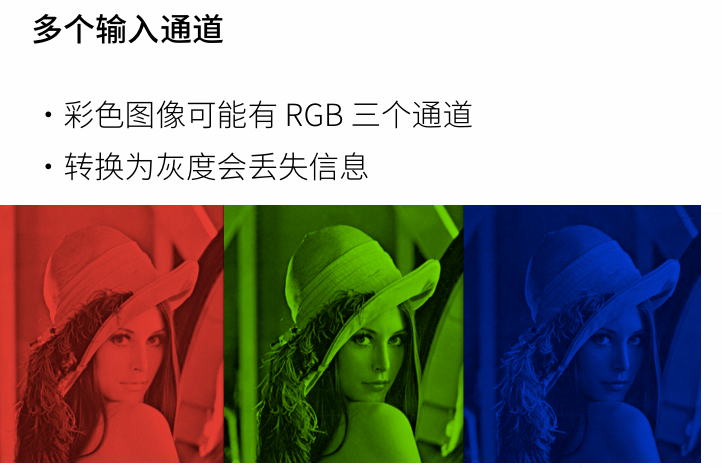

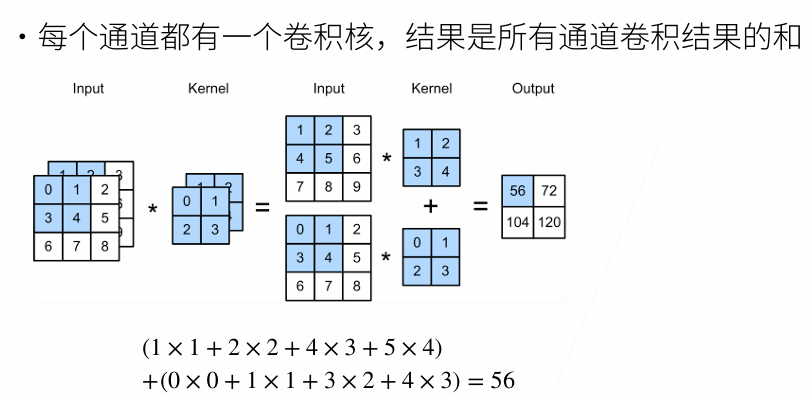

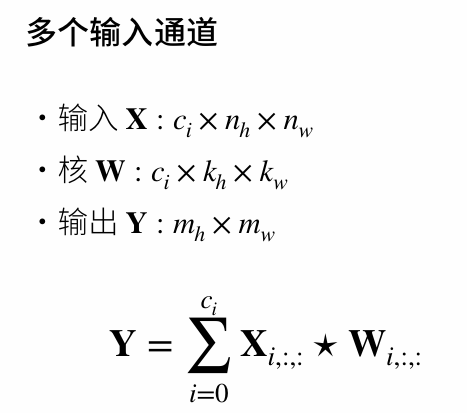

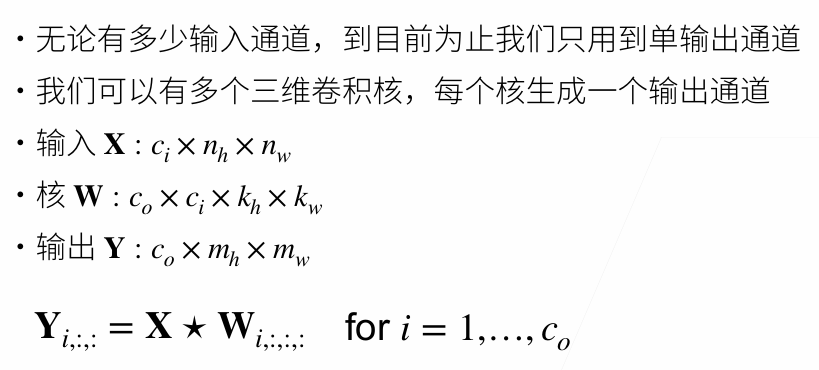

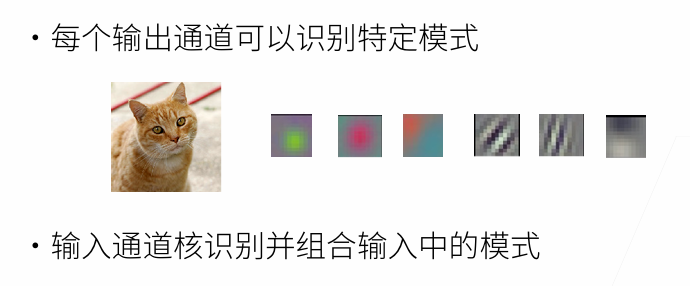

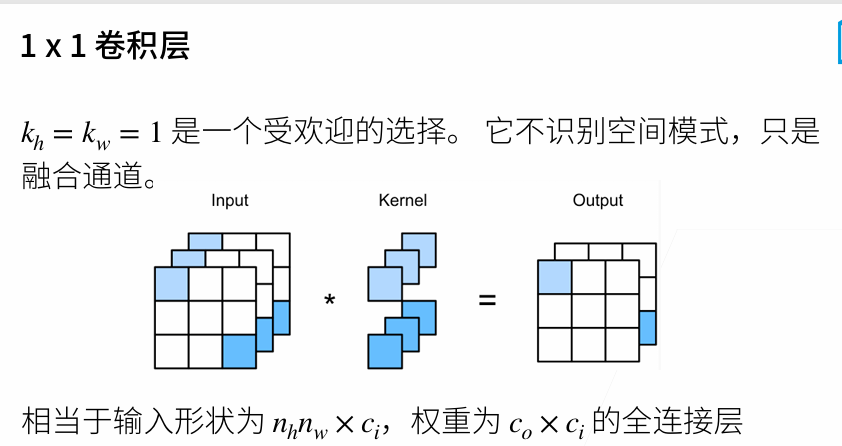

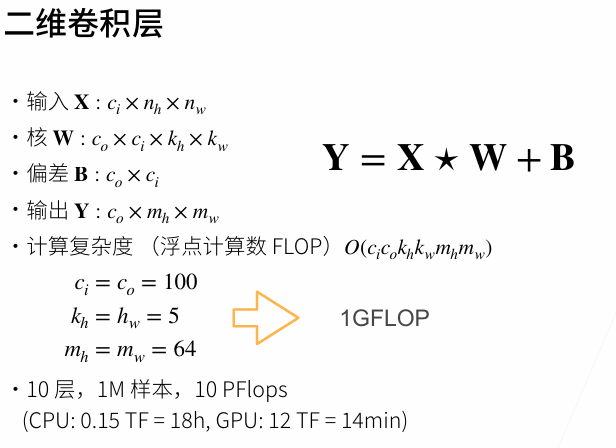

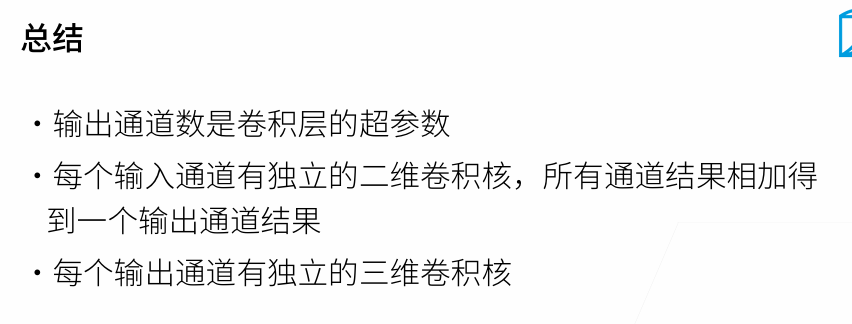

## 代码

为了加深理解，我们实现一下多输入通道互相关运算。 简而言之，我们所做的就是对每个通道执行互相关操作，然后将结果相加。

In [1]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

我们可以构造与 图6.4.1中的值相对应的输入张量X和核张量K，以验证互相关运算的输出。

In [2]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

关于多输出通道

如下所示，我们实现一个计算多个通道的输出的互相关函数。

In [3]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

通过将核张量K与K+1（K中每个元素加1）和K+2连接起来，构造了一个具有3个输出通道的卷积核。

In [4]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

下面，我们对输入张量X与卷积核张量K执行互相关运算。现在的输出包含3个通道，第一个通道的结果与先前输入张量X和多输入单输出通道的结果一致。

In [5]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

下面，我们使用全连接层实现1x1卷积。 请注意，我们需要对输入和输出的数据形状进行调整。

In [6]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

当执行1x1卷积运算时，上述函数相当于先前实现的互相关函数corr2d_multi_in_out。让我们用一些样本数据来验证这一点

In [7]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6